In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score


Predict diabetes based on demographics and habits.

In [4]:
data = pd.read_csv('nhis_2022.csv')
pd.set_option('display.max_columns', None)
data.head()

,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,ASTATFLG,CSTATFLG,AGE,SEX,MARSTCUR,EDUC,HOURSWRK,POVERTY,HEIGHT,WEIGHT,BMICALC,HINOTCOVE,CANCEREV,CHEARTDIEV,DIABETICEV,HEARTATTEV,STROKEV,ALCANYNO,ALCDAYSYR,CIGDAYMO,MOD10DMIN,VIG10DMIN,FRUTNO,VEGENO,JUICEMNO,SALADSNO,BEANNO,SALSAMNO,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,1,0,61,1,1,201,45,34,69,260,38.4,1,1,1,1,1,1,2,104,96,0,0,5,15,0,10,5,5,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,1,0,43,1,1,301,45,37,70,190,27.3,1,1,1,1,1,1,1,52,96,20,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,0,1,12,2,0,0,0,37,60,96,18.7,1,0,0,1,0,0,996,996,96,0,0,996,996,996,996,996,996,996,996,996,996,996,996,996,996,0,2
3,2022,3,134,13,0002022H000006,2,1,0002022H00000610,H000006,2681.0,1,0,68,1,5,505,0,31,75,200,25.0,1,1,1,1,1,1,7,364,96,60,0,3,1,0,1,1,2,1,1,1,0,2,0,1,1,6,2
4,2022,4,106,53,0002022H000007,3,1,0002022H00000710,H000007,10233.0,1,0,73,1,1,201,0,32,71,172,24.0,1,1,1,1,1,1,0,0,96,690,0,2,4,0,4,2,0,3,30,5,1,0,30,6,2,8,2


In [6]:
data.columns

Index(['YEAR', 'SERIAL', 'STRATA', 'PSU', 'NHISHID', 'REGION', 'PERNUM',
       'NHISPID', 'HHX', 'SAMPWEIGHT', 'ASTATFLG', 'CSTATFLG', 'AGE', 'SEX',
       'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT', 'WEIGHT',
       'BMICALC', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV', 'DIABETICEV',
       'HEARTATTEV', 'STROKEV', 'ALCANYNO', 'ALCDAYSYR', 'CIGDAYMO',
       'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO', 'HRSLEEP',
       'CVDSHT'],
      dtype='object')

In [8]:
# Removing the codes where the label is unknown
data.replace([996,997,998,999],np.nan,inplace = True)
data = (data[~data['SEX'].isin([7,8,9])]
        [~data['MARSTCUR'].isin([0,9])]
        [~data[['CANCEREV', 'CHEARTDIEV', 'DIABETICEV','STROKEV','HEARTATTEV']].isin([0, 7, 8, 9]).any(axis=1)]).reset_index(drop = True)

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/1333797734.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = (data[~data['SEX'].isin([7,8,9])]
/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/1333797734.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = (data[~data['SEX'].isin([7,8,9])]


In [10]:
demographic_data = data.loc[:,['AGE','SEX','MARSTCUR', 'EDUC','BMICALC','REGION']]
disease_indicator = data.loc[:,'DIABETICEV']
habits_data = data.loc[:,['ALCANYNO','ALCDAYSYR','CIGDAYMO', 'MOD10DMIN', 'VIG10DMIN', 'HRSLEEP']]
food_data = data.loc[:,['FRUTNO','VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO']]


In [12]:
#Checking if there is data with age < 18
data[data['AGE']<18].shape

(0, 48)

In [14]:
#Number of nan values present after replacing codes with nan
data.isnull().any(axis=1).sum()

5507

In [16]:
# Function to check unique values/labels in each column
def getUniqueColumns(data):
    for col in data.columns:
        print(f"'{col}':{data[col].unique()}")

In [18]:
getUniqueColumns(data);

'YEAR':[2022]
'SERIAL':[1.0000e+00 2.0000e+00 3.0000e+00 ... 2.8851e+04 2.8852e+04 2.8853e+04]
'STRATA':[143 106 134 127 111 105 113 115 101 118 141 126 109 147 119 137 145 132
 123 130 116 151 124 112 120 121 142 136 108 117 107 149 102 131 104 122
 150 100 144 125 140 135 129 148 133 139 114 138 146 110 103 128]
'PSU':[ 16  53  13  26  11  14  61  22  17 100  31  21   5  46  59  48   2  60
   1  28  50  47  45   9 102  35  24  34 110  27  10 151   3  52  19  51
  54  91  18  42  36  38  25 134   4  72 101  58  39  55  75 150  23   8
  49   6   7  77  43  12  64  89  20  97  32 103  74  57  80  37  15  33
  92  29  73  65  66 114  44 109  41  62 104 152  68  81 108  63  56 139
  67  93 153  87  30 127  82  76  40 115  79  78 128 140]
'NHISHID':['0002022H000001' '0002022H000003' '0002022H000006' ... '0002022H067791'
 '0002022H067792' '0002022H067793']
'REGION':[4 3 2 1]
'PERNUM':[1]
'NHISPID':['0002022H00000110' '0002022H00000310' '0002022H00000610' ...
 '0002022H06779110' '0002022H067

In [20]:
data['MARSTCUR'].value_counts()

MARSTCUR
1    11564
8     5673
5     3620
6     2659
7     1761
2      657
4      377
3        6
Name: count, dtype: int64

### Feature Selection and recoding

In [23]:
#Concatinating the demographic details, food intake features, target variable
data = pd.concat([demographic_data, food_data, disease_indicator],axis=1)
data.head()

,AGE,SEX,MARSTCUR,EDUC,BMICALC,REGION,FRUTNO,VEGENO,JUICEMNO,SALADSNO,BEANNO,SALSAMNO,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,DIABETICEV
0,61.0,1,1,201.0,38.4,4,5.0,15.0,0.0,10.0,5.0,5.0,2.0,0.0,110.0,3.0,0.0,0.0,3.0,2.0,1
1,43.0,1,1,301.0,27.3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1
2,68.0,1,5,505.0,25.0,2,3.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,1
3,73.0,1,1,201.0,24.0,3,2.0,4.0,0.0,4.0,2.0,0.0,3.0,30.0,5.0,1.0,0.0,30.0,6.0,2.0,1
4,73.0,1,1,201.0,26.5,2,1.0,2.0,10.0,5.0,0.0,0.0,4.0,5.0,3.0,3.0,3.0,0.0,1.0,1.0,1


In [25]:
data.dropna(inplace=True)

In [27]:
#Checking if there are any null values
data.isnull().any(axis=1).sum()

0

In [29]:
#Renaming the labelled values of marrital status 'MARSTCUR' and performing one hot encoding
data['MARSTCUR'] = data['MARSTCUR'].replace({1:'Married_SP', 2:'Married_SA', 3:'Married_SU', 4:'Seperated', 5:'Divorced', 6:'Widowed', 7:'Living_WP',8:'Never_Married'})
data = pd.get_dummies(data, columns=['MARSTCUR'], drop_first=True)

In [31]:
#recoding the education values into 6 labels
def recode_educ(x):
    if 100 <= x <= 116:
        return 1
    elif 200 <= x <= 202:
        return 2
    elif 300 <= x <= 303:
        return 3
    elif x == 400:
        return 4
    elif 500 <= x <= 503 or x == 505:
        return 5
    elif x == 504:
        return 6
    else:
        return np.nan  # For NIU, 996-999, and invalid codes

# Apply the function
data['EDUC'] = data['EDUC'].apply(recode_educ)
#data = pd.get_dummies(data, columns=['EDUC_LEVEL'], drop_first=True)

In [33]:
data.head()

,AGE,SEX,EDUC,BMICALC,REGION,FRUTNO,VEGENO,JUICEMNO,SALADSNO,BEANNO,SALSAMNO,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,DIABETICEV,MARSTCUR_Living_WP,MARSTCUR_Married_SA,MARSTCUR_Married_SP,MARSTCUR_Married_SU,MARSTCUR_Never_Married,MARSTCUR_Seperated,MARSTCUR_Widowed
0,61.0,1,2,38.4,4,5.0,15.0,0.0,10.0,5.0,5.0,2.0,0.0,110.0,3.0,0.0,0.0,3.0,2.0,1,False,False,True,False,False,False,False
1,43.0,1,3,27.3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1,False,False,True,False,False,False,False
2,68.0,1,5,25.0,2,3.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,1,False,False,False,False,False,False,False
3,73.0,1,2,24.0,3,2.0,4.0,0.0,4.0,2.0,0.0,3.0,30.0,5.0,1.0,0.0,30.0,6.0,2.0,1,False,False,True,False,False,False,False
4,73.0,1,2,26.5,2,1.0,2.0,10.0,5.0,0.0,0.0,4.0,5.0,3.0,3.0,3.0,0.0,1.0,1.0,1,False,False,True,False,False,False,False


In [35]:
#Finding total number of points in each class
data['DIABETICEV'].value_counts()

DIABETICEV
1    21211
2     2434
Name: count, dtype: int64

In [37]:
# Mapping ({1,2} to {0,1} which indicates 0: No diabetes and 1: diabetes
data['DIABETICEV'] = data['DIABETICEV'].map(lambda x: 0 if x == 1 else 1)
data['DIABETICEV'].value_counts()

DIABETICEV
0    21211
1     2434
Name: count, dtype: int64

In [39]:
data.columns

Index(['AGE', 'SEX', 'EDUC', 'BMICALC', 'REGION', 'FRUTNO', 'VEGENO',
       'JUICEMNO', 'SALADSNO', 'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO',
       'FRIESPNO', 'SPORDRMNO', 'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO',
       'PIZZANO', 'DIABETICEV', 'MARSTCUR_Living_WP', 'MARSTCUR_Married_SA',
       'MARSTCUR_Married_SP', 'MARSTCUR_Married_SU', 'MARSTCUR_Never_Married',
       'MARSTCUR_Seperated', 'MARSTCUR_Widowed'],
      dtype='object')

In [41]:
data.shape

(23645, 27)

Data from Region 3 (South) is selected for focused diabetes prediction.

In [43]:
## In order to reduce the size i'm interested in predicting diabetes in west region
region_specific =  data[data['REGION']==3]
#X = region_specific.drop(columns=['DIABETICEV'],axis=1)
#Y = region_specific['DIABETICEV']

## SVM Model with linear kernel

In [46]:
# function which takes input data and group_name {female, male}
# Splits the data into training and testing and predict the best model using GridSearchCV
# Also gives the feature importance using permutation_importance
# Finally gives the plot between the target variable and each of the top 5 predictors
def SVM_linear(data, group_name):
    X = data.drop(columns=['DIABETICEV'],axis=1)
    Y = data['DIABETICEV']
    scaler = StandardScaler()
    X_linear = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 1)
    params = {'C': [0.01,0.1,1,5]}
    model = SVC(kernel = 'linear', class_weight = 'balanced', random_state = 1)
    
    linear_grid = GridSearchCV(
        estimator = model,
        param_grid = params,
        scoring = 'f1_weighted',
        cv = 5,
        n_jobs = -1,
        verbose = 1
    )
    linear_grid.fit(X_train, y_train)
    best_svc_model = linear_grid.best_estimator_
    
    #feature importance
    result = permutation_importance(best_svc_model, X_test, y_test, n_repeats=5, random_state=1)
    importance_df = pd.DataFrame({'feature': X.columns, 'importance': result.importances_mean})
    importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    print(importance_df)
    # 5. View
    #print(feature_importance)
    print(linear_grid.best_params_)
    print(linear_grid.best_score_)
    print(classification_report(y_test, linear_grid.predict(X_test), zero_division = 0))
    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance_df.head(5), y='importance', x='feature', palette='viridis')
    plt.title('Top 5 Important Predictors (Permutation Importance)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    # Get the top 5 important variables
    #top_5_vars = importance_df.iloc[:5]['feature'].tolist()
    #importance_df.loc
    # Plot countplots for each of the top 5 variables
    #for var in top_5_vars:
        #plt.figure(figsize=(15, 15))
        # Plot
        #sns.lineplot(data=data.groupby('AGE')['DIABETICEV'].mean().reset_index(), x='AGE', y='DIABETICEV')
        #plt.ylabel("Proportion with Diabetes")
        #plt.title("Proportion of Diabetes Cases by Age")
        #plt.show()
        #sns.countplot(x=var, hue = 'DIABETICEV', data = data)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
                   feature  importance
0                      AGE    0.030028
1                  BMICALC    0.012709
2                 SALSAMNO    0.001676
3      MARSTCUR_Married_SA    0.000838
4              FRTDRINKMNO    0.000838
5       MARSTCUR_Seperated    0.000000
6      MARSTCUR_Married_SU    0.000000
7                      SEX    0.000000
8         MARSTCUR_Widowed    0.000000
9                   REGION    0.000000
10  MARSTCUR_Never_Married   -0.000140
11      MARSTCUR_Living_WP   -0.000279
12                POTATONO   -0.000838
13              COFETEAMNO   -0.001536
14                JUICEMNO   -0.001676
15     MARSTCUR_Married_SP   -0.001816
16                 SODAPNO   -0.001955
17                 PIZZANO   -0.002095
18                FRIESPNO   -0.002235
19               SPORDRMNO   -0.002374
20                  FRUTNO   -0.002374
21                  BEANNO   -0.002374
22                SALADSNO   -0.002654
23  

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/1050174867.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(5), y='importance', x='feature', palette='viridis')


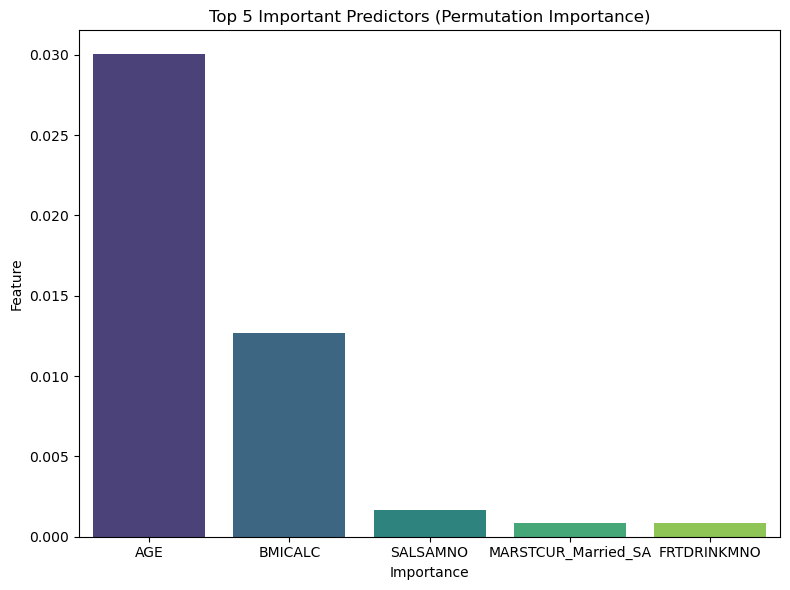

In [48]:
#Train the model and predict the diabetes among females
SVM_linear(region_specific[region_specific['SEX'] == 2], 'Female')

In [50]:
#Selecting 2 features from the feature importance and predicting the model with the best parameters found using GridSearchCV
top_features = region_specific[['AGE','DIABETICEV','BMICALC']]
X_top = top_features.drop(['DIABETICEV'],axis=1)
Y_top = top_features['DIABETICEV']
X_train, X_test, y_train, y_test = train_test_split(X_top,Y_top, test_size = 0.3, random_state = 1)

#Standardizing the input features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train)
X_test_top_scaled = scaler_top.transform(X_test)
svc_model = SVC(kernel = 'linear', C=0.01, class_weight = 'balanced', random_state = 1)
svc_model.fit(X_train_top_scaled, y_train)


SVC(C=0.01, class_weight='balanced', kernel='linear', random_state=1)

In [52]:
top_features.shape

(8672, 3)

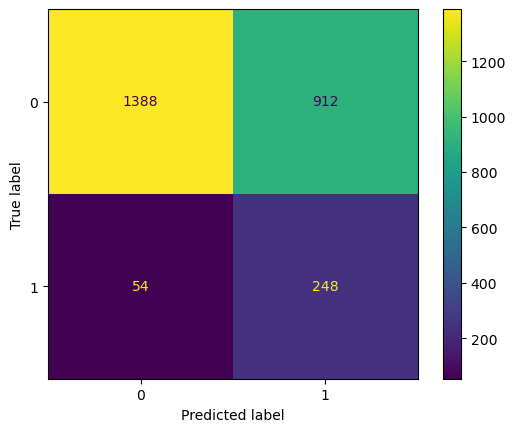

In [54]:
#Confusion Matrix display for the test data
y_pred = svc_model.predict(X_test_top_scaled)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp

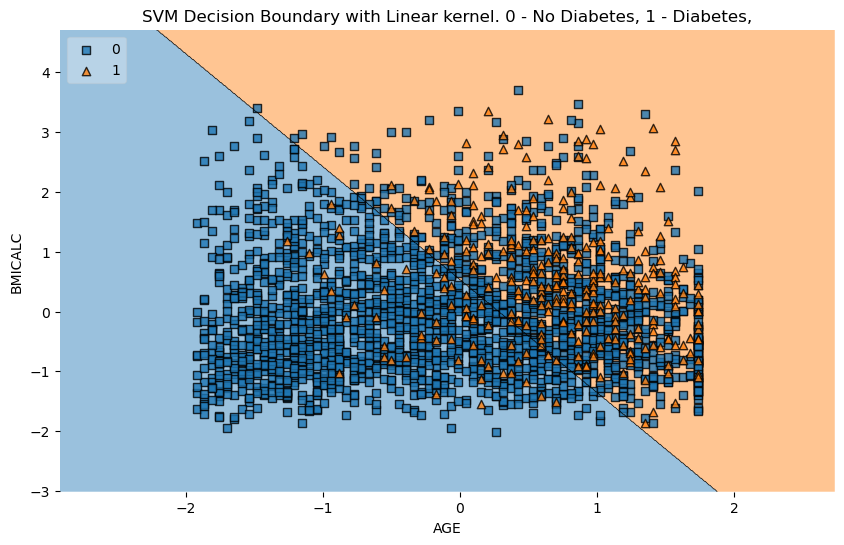

In [56]:
# Plot the decision boundary for linear SVM
plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test.to_numpy(), clf=svc_model, legend=2)
plt.xlabel(X_top.columns[0])
plt.ylabel(X_top.columns[1])
plt.title('SVM Decision Boundary with Linear kernel. 0 - No Diabetes, 1 - Diabetes,')
plt.show()

Seems like a decent boundary. Not too good though. Likely because of class imbalance.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
                   feature  importance
0                      AGE    0.036923
1                 FRIESPNO    0.003248
2                  BMICALC    0.002564
3                   VEGENO    0.002393
4              TOMSAUCEMNO    0.002222
5      MARSTCUR_Married_SP    0.001026
6         MARSTCUR_Widowed    0.000684
7   MARSTCUR_Never_Married    0.000171
8                      SEX    0.000000
9      MARSTCUR_Married_SU    0.000000
10                  REGION    0.000000
11                  BEANNO   -0.000171
12                SALADSNO   -0.000342
13     MARSTCUR_Married_SA   -0.000513
14              COFETEAMNO   -0.000684
15      MARSTCUR_Living_WP   -0.000684
16      MARSTCUR_Seperated   -0.000855
17                SALSAMNO   -0.001197
18             FRTDRINKMNO   -0.001368
19                  FRUTNO   -0.001709
20                    EDUC   -0.003590
21                 SODAPNO   -0.003761
22               SPORDRMNO   -0.005641
23  

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/1050174867.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(5), y='importance', x='feature', palette='viridis')


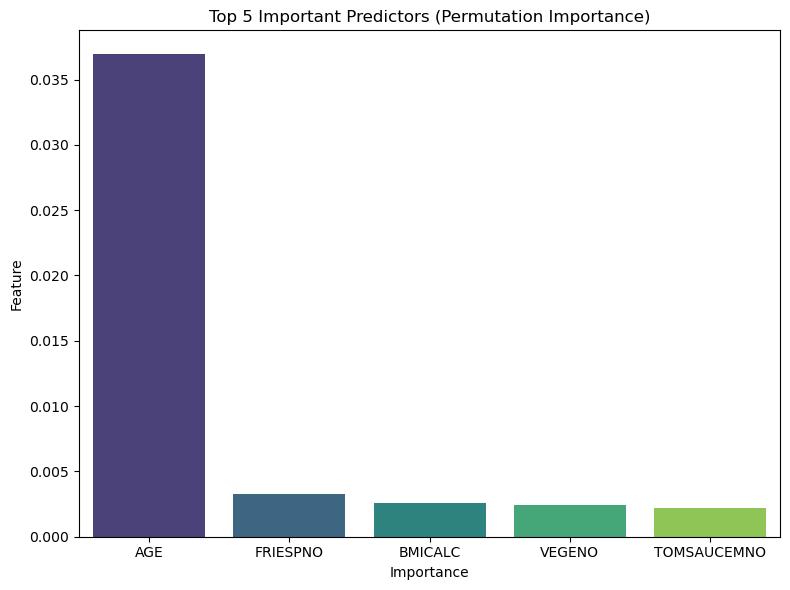

In [57]:
#Train the svm model using linear kernel using the function SVM_linear and predict the diabetes among males

SVM_linear(region_specific[region_specific['SEX'] == 1], 'Male')

## SVM Model with RBF kernel

In [60]:
# function which takes input data and group_name {female, male}
# Splits the data into training and testing and predict the best model using GridSearchCV
# training the SVM model using RBF kernel
# Also gives the feature importance using permutation_importance
# Finally gives the plot between the target variable and each of the top 5 predictors
def SVM_rbf(data, group_name):
    X = data.drop(columns=['DIABETICEV'],axis=1)
    Y = data['DIABETICEV']
    scaler = StandardScaler()
    X_linear = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 1)
    params = {'C':[0.01,0.1,1,5,10],
             'gamma': [0.5, 1, 2, 3, 4]}
    rbf_model = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 1)
    rbf_grid = GridSearchCV(
        estimator = rbf_model,
        param_grid = params,
        scoring = 'f1_weighted',
        cv = 5,
        n_jobs = -1,
        verbose = 1
    )    
    rbf_grid.fit(X_train, y_train)
    best_svm_rbf_model = rbf_grid.best_estimator_
    feature_importance = permutation_importance(best_svm_rbf_model, X_train, y_train, n_repeats = 5, random_state=1)
    importance_rbf_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance.importances_mean})
    importance_rbf_df = importance_rbf_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    print(importance_rbf_df)
    plt.figure(figsize=(8, 6))
    sns.barplot(data=importance_rbf_df.head(5), y='importance', x='feature', palette='viridis')
    plt.title('Top 5 Important Predictors (Permutation Importance)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print(f"Results for {group_name}:")
    print(rbf_grid.best_params_)
    print(rbf_grid.best_score_)
    print(classification_report(y_test, rbf_grid.predict(X_test), zero_division = 0))
    #top_5_features = importance_rbf_df[:5]['feature'].tolist()
    #for fea in top_5_features:
        #plt.figure(figsize=(15, 15))
        #sns.countplot(x=fea, hue = 'DIABETICEV', data = data)
        #plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
                   feature  importance
0                      AGE    0.109488
1                  BMICALC    0.102724
2                 SALADSNO    0.067585
3                   VEGENO    0.063334
4                   FRUTNO    0.062377
5                 POTATONO    0.056630
6                 FRIESPNO    0.052439
7                   BEANNO    0.052200
8                  SODAPNO    0.051841
9               COFETEAMNO    0.050584
10                    EDUC    0.047351
11                JUICEMNO    0.043819
12             TOMSAUCEMNO    0.042323
13                SALSAMNO    0.042323
14                 PIZZANO    0.034301
15             FRTDRINKMNO    0.027297
16               SPORDRMNO    0.022688
17                     SEX    0.000000
18                  REGION    0.000000
19      MARSTCUR_Living_WP    0.000000
20     MARSTCUR_Married_SA    0.000000
21     MARSTCUR_Married_SP    0.000000
22     MARSTCUR_Married_SU    0.000000
23

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/3060323146.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_rbf_df.head(5), y='importance', x='feature', palette='viridis')


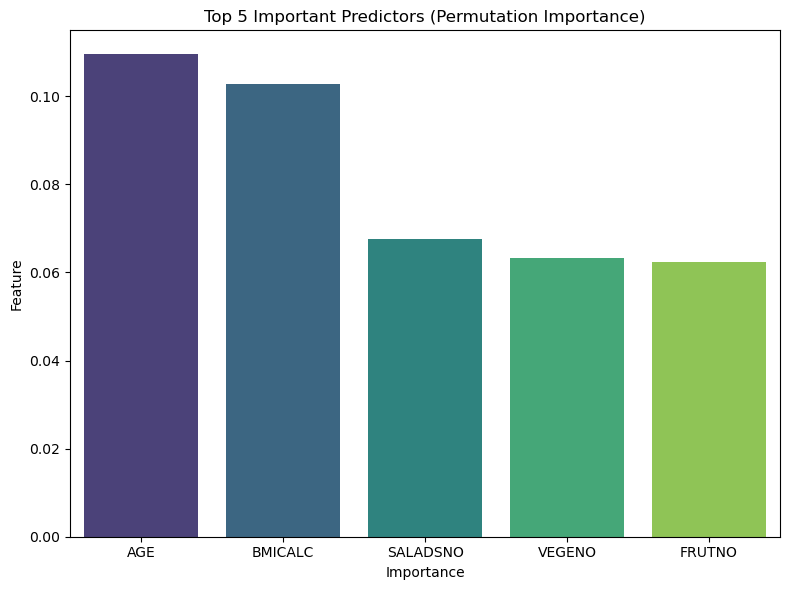

Results for Female:
{'C': 1, 'gamma': 0.5}
0.8306702484506946
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1263
           1       0.00      0.00      0.00       169

    accuracy                           0.88      1432
   macro avg       0.44      0.50      0.47      1432
weighted avg       0.78      0.88      0.83      1432



In [63]:
#Train the svm model using linear kernel using the function SVM_rbf and predict the diabetes among females

SVM_rbf(region_specific[region_specific['SEX'] == 2], 'Female')

In [64]:
#Selecting 2 features from the feature importance and predicting the model with the best parameters found using GridSearchCV

top_features_rbm = region_specific[['AGE','DIABETICEV','BMICALC']]
X_top = top_features_rbm.drop(['DIABETICEV'],axis =1)
Y_top = top_features_rbm['DIABETICEV']
X_train, X_test, y_train, y_test = train_test_split(X_top,Y_top, test_size = 0.3, random_state = 1)

#Standardizing the input features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train)
X_test_top_scaled = scaler_top.transform(X_test)
svc_model_rbf = SVC(kernel = 'rbf', C=1, class_weight = 'balanced', random_state = 1)
svc_model_rbf.fit(X_train_top_scaled, y_train)


SVC(C=1, class_weight='balanced', random_state=1)

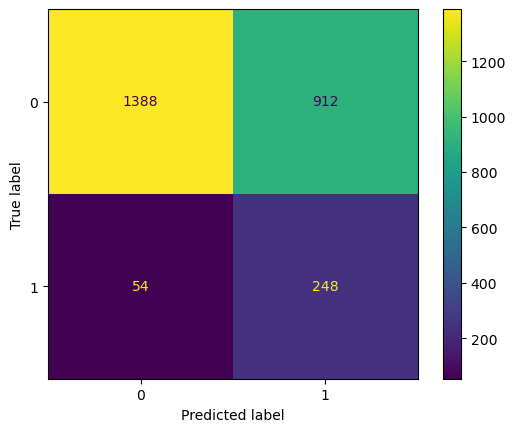

In [67]:
y_pred = svc_model_rbf.predict(X_test_top_scaled)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp

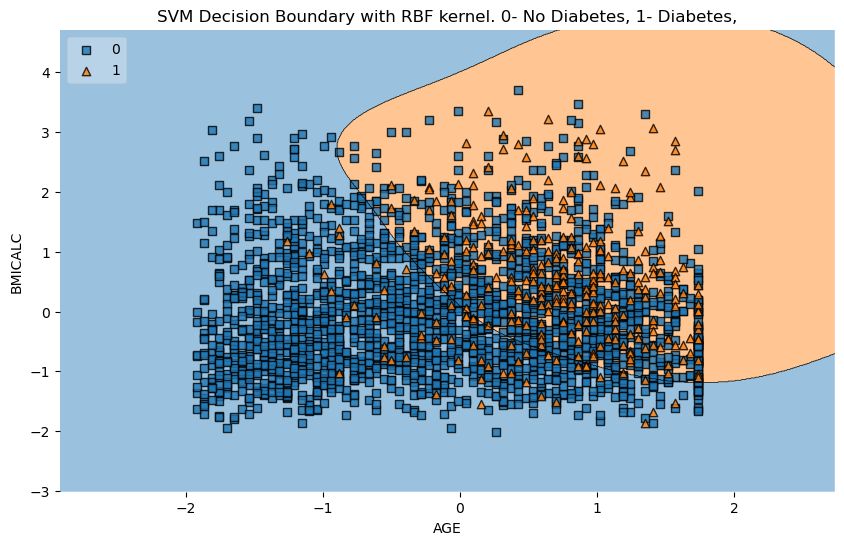

In [69]:
#Plotting the decision boundary for RBF kernel
plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test.to_numpy(), clf=svc_model_rbf, legend=2)
plt.xlabel(X_top.columns[0])
plt.ylabel(X_top.columns[1])
plt.title('SVM Decision Boundary with RBF kernel. 0- No Diabetes, 1- Diabetes,')
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
                   feature  importance
0                      AGE    0.118139
1                  BMICALC    0.107072
2                   VEGENO    0.072701
3                   FRUTNO    0.068890
4                 SALADSNO    0.066984
5                   BEANNO    0.058630
6                 POTATONO    0.058117
7                 FRIESPNO    0.056871
8                  SODAPNO    0.055038
9               COFETEAMNO    0.052913
10                    EDUC    0.051887
11             TOMSAUCEMNO    0.050788
12                SALSAMNO    0.049102
13                JUICEMNO    0.048809
14                 PIZZANO    0.037083
15               SPORDRMNO    0.036350
16             FRTDRINKMNO    0.026823
17                     SEX    0.000000
18                  REGION    0.000000
19      MARSTCUR_Living_WP    0.000000
20     MARSTCUR_Married_SA    0.000000
21     MARSTCUR_Married_SP    0.000000
22     MARSTCUR_Married_SU    0.000000
23

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/3060323146.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_rbf_df.head(5), y='importance', x='feature', palette='viridis')


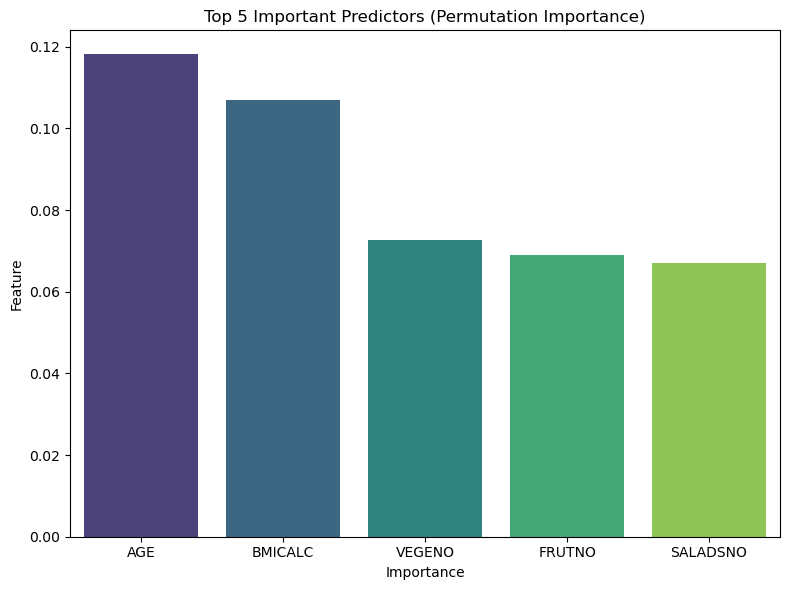

Results for Male:
{'C': 1, 'gamma': 0.5}
0.8183065394980649
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1024
           1       0.00      0.00      0.00       146

    accuracy                           0.88      1170
   macro avg       0.44      0.50      0.47      1170
weighted avg       0.77      0.88      0.82      1170



In [71]:
#Train the svm model using rbf kernel using the function SVM_rbf and predict the diabetes among males

SVM_rbf(region_specific[region_specific['SEX'] == 1], 'Male')

When recall = 1 and precision = 0.88 for class 0 (No Diabetes), it means:

Recall = 1: The model correctly identified all actual class 0 instances (i.e., no diabetic individuals). There are no false negatives for class 0.

Precision = 0.88: Out of all the predictions the model labeled as class 0, 88% were actually correct. The remaining 12% were false positives, meaning the model incorrectly labeled diabetic individuals as non-diabetic.

## SVM Model with Polynomial Kernel

In [76]:
def SVM_poly(data, group_name):
    X = data.drop(columns=['DIABETICEV'],axis=1)
    Y = data['DIABETICEV']
    scaler = StandardScaler()
    X_linear = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 1)
    params = {'C':[0.01,0.1,1,5,10],
             'degree':[2,3,4,5]}
    poly_model = SVC(kernel = 'poly', class_weight = 'balanced', random_state = 1)
    poly_grid = GridSearchCV(
        estimator = poly_model,
        param_grid = params,
        scoring = 'f1_weighted',
        cv = 5,
        n_jobs = -1,
        verbose = 1
    )
    
    poly_grid.fit(X_train, y_train)
    best_svm_poly_model = poly_grid.best_estimator_
    
    #Feature importance using permutation_importance
    important_features = permutation_importance(best_svm_poly_model, X_train, y_train, n_repeats = 5, random_state =1)
    important_df = pd.DataFrame({'feature': X.columns, 'importance': important_features.importances_mean})
    important_df = important_df.sort_values(by = 'importance', ascending=False).reset_index(drop=True)
    print(important_df)
    print(f"Results for {group_name}:")
    print(poly_grid.best_params_)
    print(poly_grid.best_score_)
    print(classification_report(y_test, poly_grid.predict(X_test), zero_division = 0))
    plt.figure(figsize=(8, 6))
    sns.barplot(data=important_df.head(5), y='importance', x='feature', palette='viridis')
    plt.title('Top 5 Important Predictors (Permutation Importance)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
                   feature  importance
0                      AGE    0.056151
1                  BMICALC    0.037594
2                 SALSAMNO    0.007124
3                   BEANNO    0.006824
4                   VEGENO    0.005328
5               COFETEAMNO    0.005268
6                 SALADSNO    0.004550
7                 FRIESPNO    0.003412
8                 POTATONO    0.003053
9                  SODAPNO    0.002754
10                    EDUC    0.002574
11             TOMSAUCEMNO    0.001078
12             FRTDRINKMNO    0.000718
13     MARSTCUR_Married_SP    0.000718
14     MARSTCUR_Married_SA    0.000599
15                JUICEMNO    0.000599
16      MARSTCUR_Seperated    0.000239
17      MARSTCUR_Living_WP    0.000060
18                     SEX    0.000000
19                  REGION    0.000000
20     MARSTCUR_Married_SU    0.000000
21               SPORDRMNO   -0.000180
22  MARSTCUR_Never_Married   -0.000599
23

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/2865896641.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=important_df.head(5), y='importance', x='feature', palette='viridis')


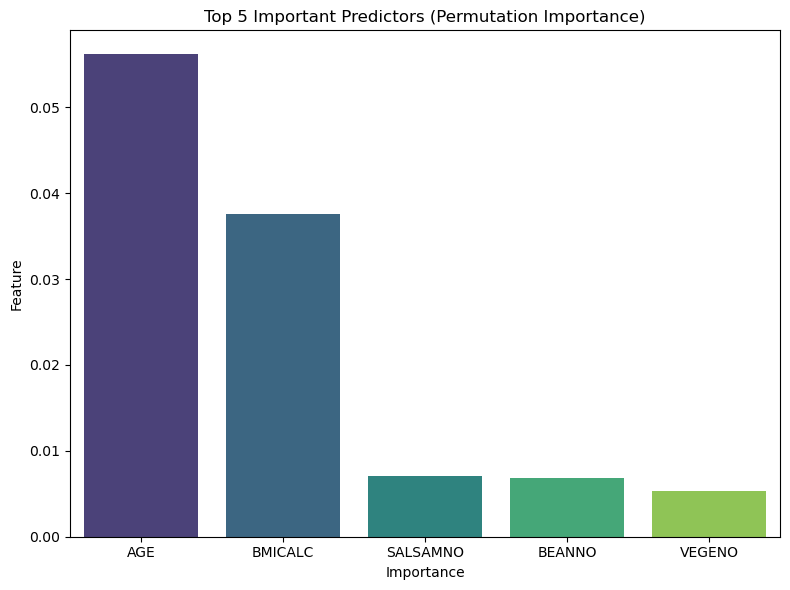

In [78]:
#Train the svm model using poly kernel using the function SVM_poly and predict the diabetes among females

SVM_poly(region_specific[region_specific['SEX'] == 2], 'Female')

In [80]:
#Selecting 2 features from the feature importance and predicting the model with the best parameters found using GridSearchCV

top_features = region_specific[['AGE', 'BMICALC', 'DIABETICEV']]
X_top = top_features.drop(['DIABETICEV'], axis =1)
Y_top = top_features['DIABETICEV']
X_train,X_test,y_train,y_test = train_test_split(X_top, Y_top, test_size = 0.3, random_state = 1)

#Standardizing the input features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train)
X_test_top_scaled = scaler_top.transform(X_test)
svc_model_poly = SVC(kernel = 'poly', C=1, degree = 5, class_weight = 'balanced', random_state = 1)
svc_model_poly.fit(X_train_top_scaled, y_train)

SVC(C=1, class_weight='balanced', degree=5, kernel='poly', random_state=1)

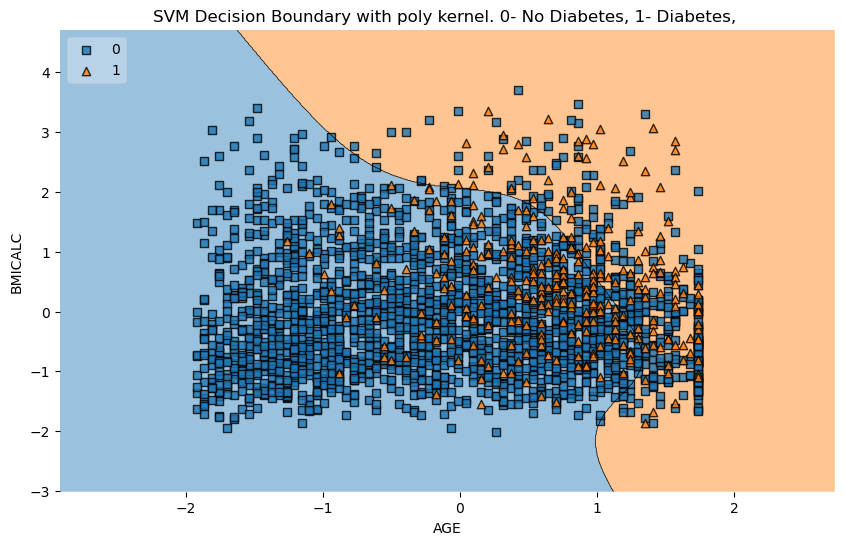

In [82]:
##Plotting the decision boundary for poly kernel

plt.figure(figsize=(10, 6))
plot_decision_regions(X_test_top_scaled, y_test.to_numpy(), clf=svc_model_poly, legend=2)
plt.xlabel(X_top.columns[0])
plt.ylabel(X_top.columns[1])
plt.title('SVM Decision Boundary with poly kernel. 0- No Diabetes, 1- Diabetes, ')
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
                   feature  importance
0                      AGE    0.044485
1                  BMICALC    0.017955
2                 SALADSNO    0.013338
3                   VEGENO    0.010187
4                 POTATONO    0.007842
5               COFETEAMNO    0.006669
6              TOMSAUCEMNO    0.006376
7                   BEANNO    0.004690
8                 FRIESPNO    0.003664
9                 SALSAMNO    0.002565
10                  FRUTNO    0.002345
11                    EDUC    0.000879
12      MARSTCUR_Living_WP    0.000806
13               SPORDRMNO    0.000660
14      MARSTCUR_Seperated    0.000147
15     MARSTCUR_Married_SP    0.000073
16        MARSTCUR_Widowed    0.000073
17                  REGION    0.000000
18                     SEX    0.000000
19     MARSTCUR_Married_SU    0.000000
20     MARSTCUR_Married_SA   -0.000073
21  MARSTCUR_Never_Married   -0.000073
22             FRTDRINKMNO   -0.000440
23

/var/folders/y4/fkn560k16c3__twnyy0m4jxr0000gn/T/ipykernel_2047/2865896641.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=important_df.head(5), y='importance', x='feature', palette='viridis')


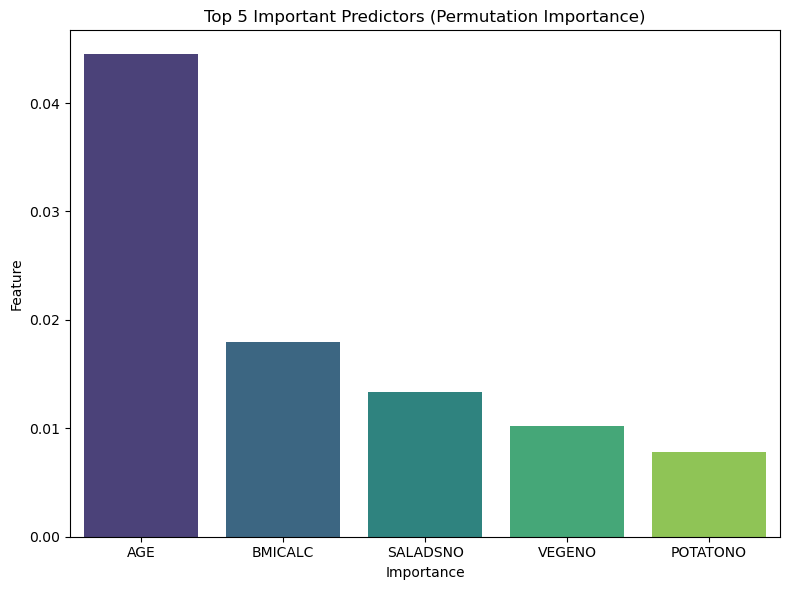

In [84]:
#Train the svm model using poly kernel using the function SVM_poly and predict the diabetes among males

SVM_poly(region_specific[region_specific['SEX'] == 1], 'Male')

The model performs well in avoiding false positives for class 0 (healthy individuals), but it's less reliable when predicting diabetes.

Recall for diabetes is moderate, which is encouraging — it catches many cases, but the low precision means it also includes many incorrect predictions.

These results highlight the need for better handling of class imbalance, possibly through resampling techniques or more balanced metrics during training.